# Calculating the COVID-19 mobility change impact on TfL Tube in London

In [1]:
# importing packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statistics import median

In [2]:
# importing data from the csv-files
path_mobility_report = 'Global_Mobility_Report.csv'
path_transport_report = 'Transport_Use_Report.csv'
path_transport_report0 = 'Transport_Use_Report0.csv'

df_mobility = pd.read_csv(path_mobility_report, parse_dates = ['date'], dayfirst=False) # Google mobility reports
df_transport0 = pd.read_csv(path_transport_report0, parse_dates = ['Date']) # the first UK transport dataset
df_transport = pd.read_csv(path_transport_report, parse_dates = ['Date'], dayfirst=True) # the second UK transport dataset

/snap/jupyter/6/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# cleaning the data
df_transport01 = df_transport0.transpose()
df_transport01.reset_index(level=0, inplace=True)
df_transport01.columns = ['Date', 'All motor vehicles','National rail', 'TfL - Tube % change', 'TfL - Bus % change']
df_transport01.drop(df_transport01.index[0], inplace=True)
date_df = pd.DataFrame({'year': [2020]*34,
                   'month': [2]*4+[3]*30,
                   'day': [1,27,28,29]+list(range(1,31))})
df_transport01['Date'] = pd.to_datetime(date_df)
df_transport.dropna(inplace = True)

# turn percentage into integers
def into_int(column):
    '''
    param column: a column in a dataframe / a list with percentages
    '''
    list1 = []
    for i in column:
        l = int(i[:-1])-100
        list1.append(l)
    return list1
df_transport['Percentage'] = into_int(df_transport['Percentage'])

In [7]:
# Look at how the mobility changed in the
uk_mobility = df_mobility[df_mobility['country_region'] == 'United Kingdom']


# choose the region under analysis
uk_mobility = uk_mobility[uk_mobility['sub_region_1'] == 'Greater London']
# drop the sub-region column after the region is chosen
uk_mobility.drop(columns = 'sub_region_1', inplace=True)
# choose the columns and dates required for the analysis
uk_mobility = uk_mobility.iloc[:,3:9:5]
uk_mobility = uk_mobility[uk_mobility["date"].isin(pd.date_range("2020-02-27", "2020-05-29"))]

# check for missing values
uk_mobility.isnull().any()

date                                       False
workplaces_percent_change_from_baseline    False
dtype: bool

In [5]:
# combine the data in both UK-transport reports for the needed transport type
def add_for_transport(column_name, sec_column_name):
    '''
    param column_name: name of the column in the first part of the UK-transport report
    param sec_column_name: name of the column in the second part of the UK-transport report
    '''
    type_transport = df_transport[df_transport['Transport Type'] == column_name]
    transport_add = df_transport01[df_transport01["Date"].isin(pd.date_range("2020-02-27", "2020-03-15"))][['Date',sec_column_name]]
    transport_add.columns = ['Date', 'Percentage']
    transport_add['Percentage'] = into_int(transport_add['Percentage'])

    transport_added = pd.concat([transport_add,type_transport])
    del transport_added['Transport Type']
    return transport_added
    
# combine the reports for TfL Tube
tfl_tube = add_for_transport('TfL Tube', 'TfL - Tube % change')
tfl_tube

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


,Date,Percentage
1,2020-02-27,-1
2,2020-02-28,-3
3,2020-02-29,-7
4,2020-03-01,4
5,2020-03-02,-5
...,...,...
370,2020-05-25,-91
371,2020-05-26,-91
372,2020-05-27,-92
373,2020-05-28,-91


<Figure size 1080x720 with 0 Axes>

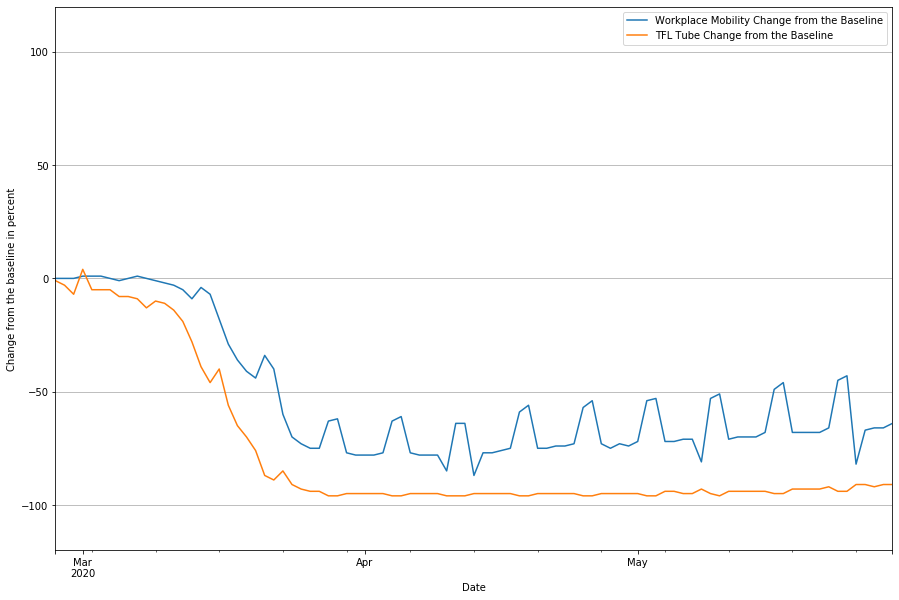

In [6]:
# plot the data on the same graph
plt.figure(figsize = (15, 10))
ax = uk_mobility.plot(figsize = (15, 10), x='date', y='workplaces_percent_change_from_baseline', label = 'Workplace Mobility Change from the Baseline')
tfl_tube.plot(x='Date', y='Percentage', label = 'TFL Tube Change from the Baseline', ax=ax)

ax.set_ylabel('Change from the baseline in percent')
ax.set_xlabel('Date')
plt.ylim(-120, 120)
plt.grid(axis='y')
plt.show()